<a href="https://colab.research.google.com/github/krish1904/krish1904/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def categorize_material(mat):
    code_part = str(mat)[3:].upper()  # Get substring after first 3 letters
    if '1D' in code_part or '5D' in code_part:
        return 'Prime'
    else:
        return 'Non-Prime'

df['Category'] = df['MAT'].apply(categorize_material)

def calc_metrics(subset):
    subset = subset[(subset['Forecast'] > 0) & (subset['TotalQty'] > 0)]
    mae = np.abs(subset['Forecast'] - subset['TotalQty']).mean()
    perc_errors = np.abs(subset['Forecast'] - subset['TotalQty']) / subset['TotalQty'] * 100
    perc_errors_capped = np.minimum(perc_errors, 100)
    wmape = np.sum(perc_errors_capped * subset['TotalQty']) / np.sum(subset['TotalQty'])
    return pd.Series({'MAE': mae, 'WMAPE': wmape})

# Group by category and calculate
metrics_by_cat = df.groupby('Category').apply(calc_metrics)

# Print or use in your PPT table
print(metrics_by_cat)



                 MAE      WMAPE
Category                       
Non-Prime  25.019228  35.900169
Prime      15.049754  28.921774


<ipython-input-4-2bdeaaf61c84>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_cat = df.groupby('Category').apply(calc_metrics)


In [ ]:
def calc_metrics_per_material(subset):
    subset = subset[(subset['Forecast'] > 0) & (subset['TotalQty'] > 0)]
    mae = np.abs(subset['Forecast'] - subset['TotalQty']).mean()
    perc_errors = np.abs(subset['Forecast'] - subset['TotalQty']) / subset['TotalQty'] * 100
    perc_errors_capped = np.minimum(perc_errors, 100)
    wmape = np.sum(perc_errors_capped * subset['TotalQty']) / np.sum(subset['TotalQty'])
    return pd.Series({'MAE': mae, 'WMAPE': wmape})

metrics_by_mat = df.groupby('MAT').apply(calc_metrics_per_material)
best_materials = metrics_by_mat.nsmallest(50, 'WMAPE')
print("Top 5 Materials (Lowest WMAPE):")
print(best_materials)


Top 5 Materials (Lowest WMAPE):
                           MAE      WMAPE
MAT                                      
GIY1E0160034100001    5.295892   3.275016
SPL1D0100096100007    0.589359  11.608667
GRY5D0150048100019    0.102616  11.864809
GIY3D0150048100001    4.074625  11.981768
GRY3D0150048100019    0.067662  12.015500
GRY2D0100144100001    0.304903  12.916873
SPL1D0090035100002    0.830419  13.044590
SPL5D0081072100022    0.644937  13.669226
GIY1E0150048100001  150.136236  14.988916
GRY1D0135120100001    2.309231  15.178572
GRY5D0050072100002    0.858521  15.652833
SPL5D0050072100004    0.260909  15.660819
SPL5D0081072100017   32.880569  15.762334
SPL1D0220145100001   24.650080  16.200284
GIY1E0330072200001   17.738625  16.349221
GRY4D0075034100001    4.921174  16.432414
SPL1D0081072100017  164.231871  16.730682
GIY4D0075034100001    0.850306  16.888195
GIY5D0075034100001   86.134147  17.255831
GRY1E0125288100001  293.039834  17.450898
GRY1D0081072100018   51.252078  17.735999
GR

<ipython-input-5-4ecbdde5efe5>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_mat = df.groupby('MAT').apply(calc_metrics_per_material)


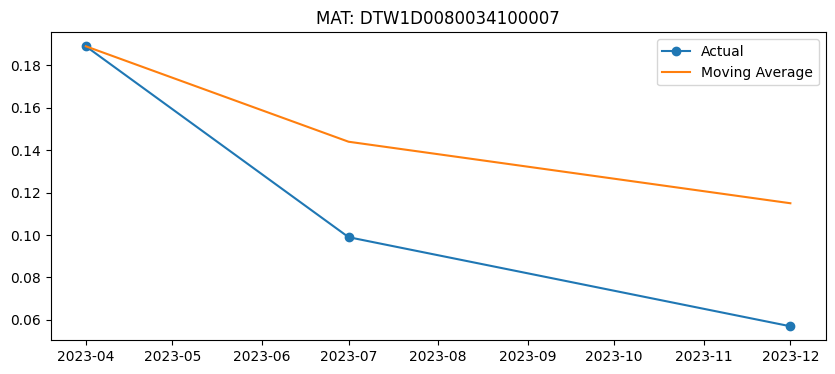

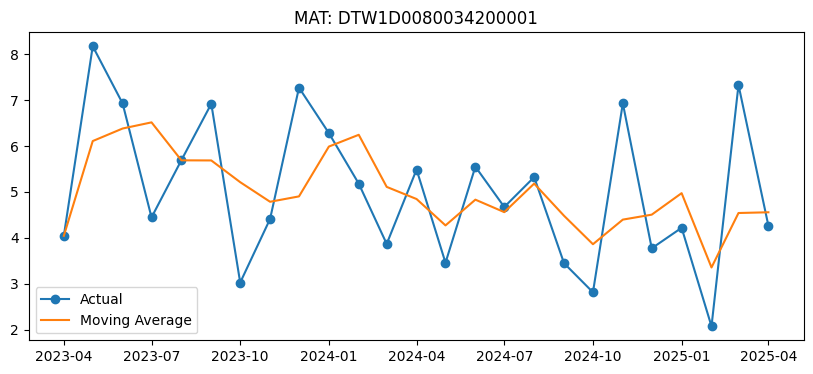

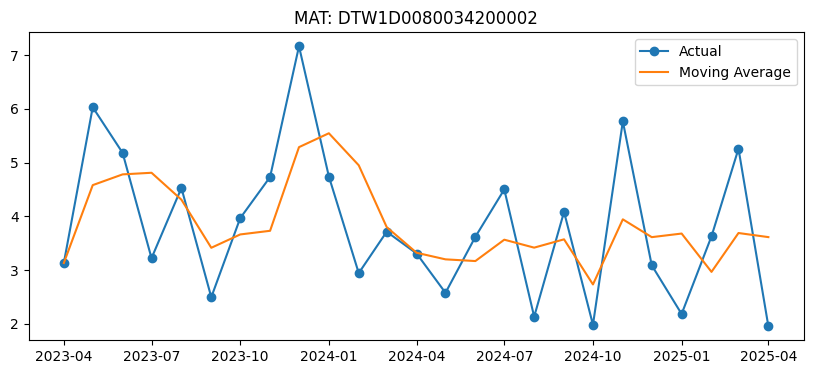

In [ ]:
import matplotlib.pyplot as plt

for mat_id in results_df['MAT'].head(3):
    subset = df[df['MAT'] == mat_id].sort_values('Date')
    y = subset.set_index('Date')['Actual']

    plt.figure(figsize=(10, 4))
    plt.plot(y.index, y, 'o-', label='Actual')

    if results_df[results_df['MAT'] == mat_id]['Best Model'].values[0] == 'LightGBM':
        X = pd.DataFrame({
            'month': y.index.month,
            'year': y.index.year,
            'lag1': y.shift(1).fillna(y.mean()),
            'lag2': y.shift(2).fillna(y.mean()),
            'rolling_mean': y.rolling(3, min_periods=1).mean()
        }).dropna()
        preds = lgb.LGBMRegressor().fit(X, y[X.index]).predict(X)
        plt.plot(X.index, preds, label='LightGBM Forecast')
    else:
        plt.plot(y.index, y.rolling(3, min_periods=1).mean(), label='Moving Average')

    plt.title(f"MAT: {mat_id}")
    plt.legend()
    plt.show()

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

# Load and prepare data
df = pd.read_excel('Frontend.xlsm', sheet_name='SalesData')
df = df.rename(columns={'Month': 'Date', 'TotalQty': 'Actual'})
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop_duplicates(['MAT', 'Date'], keep='last')

def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

results = []
for mat_id in df['MAT'].unique():
    mat_data = df[df['MAT'] == mat_id].sort_values('Date')
    y = mat_data.set_index('Date')['Actual']

    if len(y) < 3:
        continue

    # Moving Average Model
    preds_ma = y.rolling(3, min_periods=1).mean()
    metrics_ma = {
        'MAE': mean_absolute_error(y, preds_ma),
        'WMAPE': wmape(y, preds_ma),
        'RMSE': np.sqrt(mean_squared_error(y, preds_ma)),
        'MAPE': mean_absolute_percentage_error(y, preds_ma)
    }

    # LightGBM Model (if enough data)
    metrics_lgb = {'MAE': np.inf}
    if len(y) >= 6:
        try:
            X_lgb = pd.DataFrame({
                'month': y.index.month,
                'year': y.index.year,
                'lag1': y.shift(1).fillna(y.mean()),
                'lag2': y.shift(2).fillna(y.mean()),
                'rolling_mean': y.rolling(3, min_periods=1).mean()
            }).dropna()
            y_lgb = y[X_lgb.index]

            if len(X_lgb) > 0:
                model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, verbosity=-1)
                model.fit(X_lgb, y_lgb)
                preds_lgb = model.predict(X_lgb)
                metrics_lgb = {
                    'MAE': mean_absolute_error(y_lgb, preds_lgb),
                    'WMAPE': wmape(y_lgb, preds_lgb),
                    'RMSE': np.sqrt(mean_squared_error(y_lgb, preds_lgb)),
                    'MAPE': mean_absolute_percentage_error(y_lgb, preds_lgb)
                }
        except:
            pass

    # Select best model
    if metrics_lgb['MAE'] < metrics_ma['MAE']:
        best_metrics = metrics_lgb
        best_model = 'LightGBM'
    else:
        best_metrics = metrics_ma
        best_model = 'MovingAverage'

    results.append({
        'MAT': mat_id,
        'Best Model': best_model,
        'Data Points': len(y),
        **best_metrics
    })

# Create and display results
results_df = pd.DataFrame(results)
print("Complete Accuracy Report:")
print(results_df.sort_values('MAE').to_string())

# Aggregate statistics
print("\nModel Performance Summary:")
print(results_df.groupby('Best Model').agg({
    'MAE': ['mean', 'median'],
    'WMAPE': ['mean', 'median'],
    'RMSE': ['mean'],
    'MAPE': ['mean']
}))

Complete Accuracy Report:
                     MAT     Best Model  Data Points         MAE       WMAPE        RMSE        MAPE
936   GRY5D0220145100002  MovingAverage            3    0.001889    8.333333    0.002317    0.092063
80    DTW3D0150048100040  MovingAverage            3    0.001944   16.666667    0.002648    0.135732
242   DYD1D0150072100225  MovingAverage            4    0.002333    4.301075    0.004055    0.038413
79    DTW3D0150048100036  MovingAverage            6    0.002444   15.438596    0.003416    0.198748
326   DYD3D0155048100201  MovingAverage            4    0.002708   22.569444    0.003372    0.339476
328   DYD3D0155048100213  MovingAverage            4    0.003042   19.623656    0.003686    0.263889
74    DTW3D0080034200046  MovingAverage            5    0.003067   14.330218    0.004050    0.136385
213   DYD1D0150072100164  MovingAverage            8    0.003229    4.722730    0.004899    0.050285
1357  SPL4D0080072200017  MovingAverage            3    0.003444 

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

# Load and prepare data
df = pd.read_excel('Frontend prac.xlsm', sheet_name='SalesData')
df = df.rename(columns={'Month': 'Date', 'TotalQty': 'Actual'})
df['Date'] = pd.to_datetime(df['Date'])

# =============================================
# 1. MATERIAL CLASSIFICATION
# =============================================
def classify_material(mat_code):
    """Classify based on CONTAINMENT of 1d/5d vs 2d/3d/4d"""
    if pd.isna(mat_code):
        return 'Unknown'
    mat_str = str(mat_code).lower()
    if any(x in mat_str for x in ['1d', '5d']):
        return 'Prime'
    elif any(x in mat_str for x in ['2d', '3d', '4d']):
        return 'Non-Prime'
    return 'Unknown'

df['Material_Type'] = df['MAT'].apply(classify_material)

# =============================================
# 2. FILTER FOR MATERIALS WITH ≥6 MONTHS POSITIVE DATA
# =============================================
min_history = 6
valid_materials = df.groupby('MAT').filter(
    lambda x: (len(x) >= min_history) &
              (x['Actual'].gt(0).sum() >= min_history)
)['MAT'].unique()

df = df[df['MAT'].isin(valid_materials)]

# =============================================
# 3. FEATURE ENGINEERING
# =============================================
def create_features(df):
    features = pd.DataFrame({
        'month': df['Date'].dt.month,
        'year': df['Date'].dt.year,
        'lag1': df.groupby('MAT')['Actual'].shift(1).fillna(0),
        'lag2': df.groupby('MAT')['Actual'].shift(2).fillna(0),
        'rolling_mean_3': df.groupby('MAT')['Actual'].transform(
            lambda x: x.rolling(3, min_periods=1).mean()),
        'Material_Type': df['Material_Type']
    })
    return features

features = create_features(df)
target = df['Actual']

# =============================================
# 4. DATA VALIDATION
# =============================================
print("\n=== Data Summary ===")
print(f"Total materials: {df['MAT'].nunique()}")
print(df['Material_Type'].value_counts())

if 'Prime' not in df['Material_Type'].unique():
    raise ValueError("No Prime materials found! Check your MAT code patterns.")

# Filter features/target
valid_idx = features.dropna().index
features = features.loc[valid_idx]
target = target.loc[valid_idx]
features['Material_Type'] = features['Material_Type'].map({
    'Non-Prime': 0,
    'Prime': 1,
    'Unknown': -1
}).astype(int)

# =============================================
# 5. ERROR METRICS
# =============================================
def safe_mape(y_true, y_pred):
    """Handles zero/negative values by filtering"""
    mask = y_true > 0
    if sum(mask) == 0: return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def safe_wmape(y_true, y_pred):
    """Weighted MAPE that filters zeros"""
    mask = y_true > 0
    if sum(mask) == 0: return np.nan
    return np.sum(np.abs(y_true[mask] - y_pred[mask])) / np.sum(y_true[mask]) * 100

def strict_mape(y_true, y_pred):
    """Requires ALL actuals > 0"""
    if not all(y_true > 0): return np.nan
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def strict_wmape(y_true, y_pred):
    """Requires ALL actuals > 0"""
    if not all(y_true > 0): return np.nan
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

# =============================================
# 6. MODEL TRAINING
# =============================================
groups = df.loc[valid_idx, 'MAT']
gkf = GroupKFold(n_splits=3)
results = []

for fold, (train_index, test_index) in enumerate(gkf.split(features, groups=groups), 1):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    model = lgb.LGBMRegressor(
        n_estimators=250,
        learning_rate=0.2,
        verbosity=-1,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    test_data = pd.DataFrame({
        'Actual': y_test.values,
        'Prediction': preds,
        'Material_Type': X_test['Material_Type'],
        'MAT': groups.iloc[test_index].values
    })

    for mat_type in [0, 1]:
        mask = test_data['Material_Type'] == mat_type
        if sum(mask) > 0:
            y_true = test_data[mask]['Actual'].values
            y_pred = test_data[mask]['Prediction'].values

            # Calculate all metrics
            metrics = {
                'Material_Type': 'Prime' if mat_type == 1 else 'Non-Prime',
                'Fold': fold,
                'MAE': mean_absolute_error(y_true, y_pred),
                'Standard_WMAPE': safe_wmape(y_true, y_pred),
                'Standard_MAPE': safe_mape(y_true, y_pred),
                'Strict_WMAPE': strict_wmape(y_true, y_pred),
                'Strict_MAPE': strict_mape(y_true, y_pred),
                'Samples': sum(mask),
                'Positive_Samples': sum(y_true > 0),
                'Materials': len(set(test_data[mask]['MAT']))
            }
            results.append(metrics)

# =============================================
# 7. RESULTS ANALYSIS
# =============================================
if results:
    results_df = pd.DataFrame(results)

    print("\n" + "="*50)
    print("FINAL PERFORMANCE REPORT")
    print("="*50)

    # Metrics Coverage
    coverage = results_df.groupby('Material_Type').agg({
        'Strict_WMAPE': lambda x: f"{x.notna().mean()*100:.1f}%",
        'Strict_MAPE': lambda x: f"{x.notna().mean()*100:.1f}%"
    })
    print("\nStrict Metrics Coverage (All Actuals > 0):")
    print(coverage)

    # Main Results
    print("\nPerformance Metrics (Standard):")
    print(results_df.groupby('Material_Type').agg({
        'MAE': ['mean', 'std'],
        'Standard_WMAPE': ['mean', 'std'],
        'Standard_MAPE': ['mean', 'std'],
        'Samples': 'sum',
        'Positive_Samples': 'sum',
        'Materials': 'nunique'
    }))

    # Feature Importance
    model.fit(features, target)  # Retrain on full data
    fi = pd.DataFrame({
        'Feature': features.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print("\nFeature Importance:")
    print(fi)

    # Example Materials
    print("\nExample Materials (First 5 of each type):")
    for mat_type in ['Prime', 'Non-Prime']:
        examples = df[df['Material_Type'] == mat_type]['MAT'].unique()[:5]
        print(f"{mat_type}: {examples}")
else:
    print("\nERROR: No results generated. Check if:")
    print("- Materials have sufficient history (≥6 months positive)")
    print("- Both Prime and Non-Prime types exist in test folds")


=== Data Summary ===
Total materials: 1042
Material_Type
Prime        9937
Non-Prime    4406
Unknown       905
Name: count, dtype: int64

FINAL PERFORMANCE REPORT

Strict Metrics Coverage (All Actuals > 0):
              Strict_WMAPE Strict_MAPE
Material_Type                         
Non-Prime           100.0%      100.0%
Prime               100.0%      100.0%

Performance Metrics (Standard):
                    MAE           Standard_WMAPE           Standard_MAPE  \
                   mean       std           mean       std          mean   
Material_Type                                                              
Non-Prime      0.511062  0.089636      10.593396  1.632718     87.652107   
Prime          7.371987  4.887136      20.661838  5.763187     68.569870   

                         Samples Positive_Samples Materials  
                     std     sum              sum   nunique  
Material_Type                                                
Non-Prime      15.784323    4406    

<ipython-input-29-b0b1d6f32c91>:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'lag1': df.groupby('MAT')['Actual'].shift(1).fillna(method='bfill'),
<ipython-input-29-b0b1d6f32c91>:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'lag2': df.groupby('MAT')['Actual'].shift(2).fillna(method='bfill'),


Forecast Accuracy by Material Group (First 3 Characters)
                      MAE                   MAPE                  WMAPE  \
                     mean        std        mean         std       mean   
Material_Group                                                            
STW              0.004438        NaN    1.171080         NaN   1.171080   
GTW              0.510055        NaN   59.062088         NaN  12.936691   
SPL              5.090592   5.257573  182.366402    9.439091  17.241156   
GRY             25.346411  32.075251  561.399900  613.701034  39.126732   
GIY             37.539880        NaN  122.427126         NaN  55.366754   

                          Samples  
                      std     sum  
Material_Group                     
STW                   NaN       1  
GTW                   NaN     181  
SPL              0.890028    5423  
GRY             29.730871    8184  
GIY                   NaN      44  


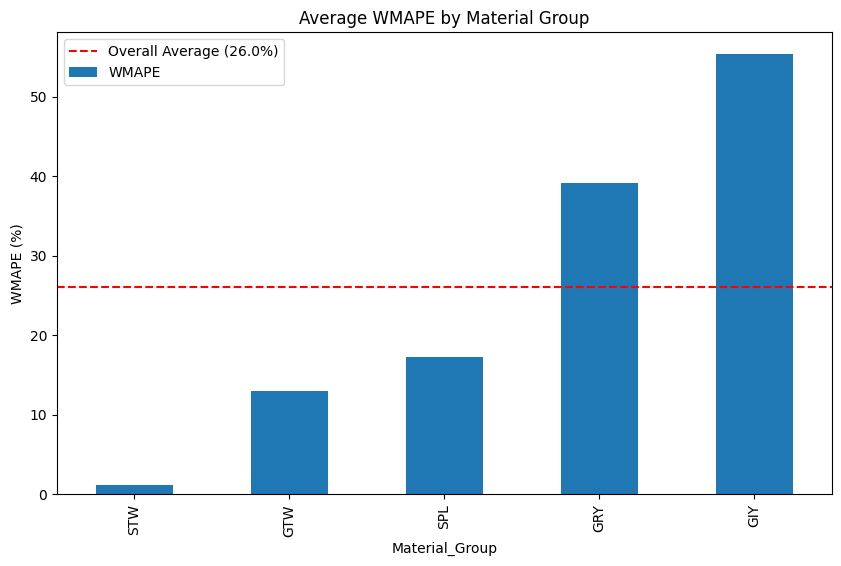

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit

def calculate_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Load your data (replace with your actual data loading)
df = pd.read_excel('Frontend prac.xlsm', sheet_name='SalesData')
df = df.rename(columns={'Month': 'Date', 'TotalQty': 'Actual'})
df['Date'] = pd.to_datetime(df['Date'])

# Extract first 3 characters as material group
df['Material_Group'] = df['MAT'].str[:3]

# Feature engineering
def create_features(df):
    features = pd.DataFrame({
        'month': df['Date'].dt.month,
        'year': df['Date'].dt.year,
        'lag1': df.groupby('MAT')['Actual'].shift(1).fillna(method='bfill'),
        'lag2': df.groupby('MAT')['Actual'].shift(2).fillna(method='bfill'),
        'rolling_mean_3': df.groupby('MAT')['Actual'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    })
    return features

features = create_features(df)
target = df['Actual']

# Time-series cross validation
tscv = TimeSeriesSplit(n_splits=3)
results = []

for train_index, test_index in tscv.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    model = LGBMRegressor(n_estimators=125, learning_rate=0.125)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Get material groups for test set
    test_groups = df.iloc[test_index]['Material_Group']

    for group in test_groups.unique():
        mask = (test_groups == group).values
        if sum(mask) > 0:  # Only calculate if group exists in test set
            y_true = y_test.iloc[mask]
            y_pred = preds[mask]

            results.append({
                'Material_Group': group,
                'MAE': mean_absolute_error(y_true, y_pred),
                'MAPE': calculate_mape(y_true, y_pred),
                'WMAPE': calculate_wmape(y_true, y_pred),
                'Samples': sum(mask)
            })

# Aggregate results
if results:
    results_df = pd.DataFrame(results)
    accuracy_by_group = results_df.groupby('Material_Group').agg({
        'MAE': ['mean', 'std'],
        'MAPE': ['mean', 'std'],
        'WMAPE': ['mean', 'std'],
        'Samples': 'sum'
    })

    print("="*50)
    print("Forecast Accuracy by Material Group (First 3 Characters)")
    print("="*50)
    print(accuracy_by_group.sort_values(('WMAPE', 'mean')))

    # Visualize results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    results_df.groupby('Material_Group')['WMAPE'].mean().sort_values().plot(
        kind='bar', title='Average WMAPE by Material Group')
    plt.ylabel('WMAPE (%)')
    plt.axhline(results_df['WMAPE'].mean(), color='red', linestyle='--',
                label=f'Overall Average ({results_df["WMAPE"].mean():.1f}%)')
    plt.legend()
    plt.show()
else:
    print("No results generated. Check if material groups have sufficient data.")

Forecast Accuracy by Material Group (First 3 Characters)
                      MAE      WMAPE Samples
                     mean       mean     sum
Material_Group                              
GTW              0.427144  10.833798     181
STW              0.041165  10.861364       1
SPL              2.291356  15.895583    5423
GIY             46.831653  32.461902     275
GRY             21.044851  41.211823    8184
DTW              0.292237  41.838633    1292
DYD              0.251218  43.557854    3088


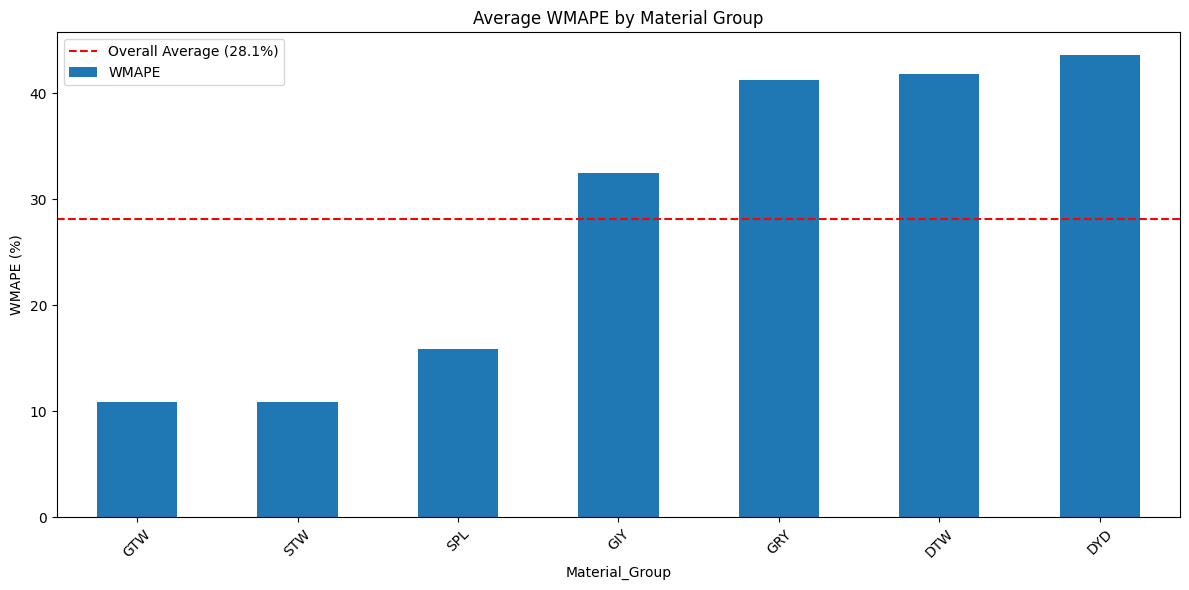

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

def calculate_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Load your data (replace with your actual data loading)
df = pd.read_excel('Frontend.xlsm', sheet_name='SalesData')
df = df.rename(columns={'Month': 'Date', 'TotalQty': 'Actual'})
df['Date'] = pd.to_datetime(df['Date'])

# Extract first 3 characters as material group
df['Material_Group'] = df['MAT'].str[:3]

# Feature engineering
def create_features(df):
    features = pd.DataFrame({
        'month': df['Date'].dt.month,
        'year': df['Date'].dt.year,
        'lag1': df.groupby('MAT')['Actual'].shift(1).fillna(0),  # Fill NA with 0
        'lag2': df.groupby('MAT')['Actual'].shift(2).fillna(0),
        'rolling_mean_3': df.groupby('MAT')['Actual'].transform(
            lambda x: x.rolling(3, min_periods=1).mean())
    })
    return features

features = create_features(df)
target = df['Actual']

# GroupKFold to ensure all material groups appear in test sets
gkf = GroupKFold(n_splits=3)
results = []

for train_index, test_index in gkf.split(features, groups=df['Material_Group']):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    test_groups = df.iloc[test_index]['Material_Group']

    model = LGBMRegressor(n_estimators=75, learning_rate=0.25, verbose=-1)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Evaluate all material groups (even if not in current test fold)
    for group in df['Material_Group'].unique():
        mask = (test_groups == group).values
        if sum(mask) > 0:  # Group exists in this test fold
            y_true = y_test.iloc[mask]
            y_pred = preds[mask]

            results.append({
                'Material_Group': group,
                'MAE': mean_absolute_error(y_true, y_pred),
                'MAPE': calculate_mape(y_true, y_pred),
                'WMAPE': calculate_wmape(y_true, y_pred),
                'Samples': sum(mask),
                'Fold': len(results) // len(df['Material_Group'].unique()) + 1
            })
        else:  # Group missing in this test fold
            results.append({
                'Material_Group': group,
                'MAE': np.nan,
                'MAPE': np.nan,
                'WMAPE': np.nan,
                'Samples': 0,
                'Fold': len(results) // len(df['Material_Group'].unique()) + 1
            })

# Aggregate results
if results:
    results_df = pd.DataFrame(results)

    # Filter out groups with no samples across all folds
    valid_groups = results_df.groupby('Material_Group')['Samples'].sum() > 0
    valid_groups = valid_groups[valid_groups].index.tolist()
    filtered_df = results_df[results_df['Material_Group'].isin(valid_groups)]

    accuracy_by_group = filtered_df.groupby('Material_Group').agg({
        'MAE': ['mean'],
        'WMAPE': ['mean'],
        'Samples': 'sum'
    })

    print("="*55)
    print("Forecast Accuracy by Material Group (First 3 Characters)")
    print("="*55)
    print(accuracy_by_group.sort_values(('WMAPE', 'mean')))

    # Visualize results
    plt.figure(figsize=(12, 6))
    (filtered_df.groupby('Material_Group')['WMAPE'].mean()
     .sort_values()
     .plot(kind='bar', title='Average WMAPE by Material Group'))
    plt.ylabel('WMAPE (%)')
    plt.axhline(filtered_df['WMAPE'].mean(), color='red', linestyle='--',
                label=f'Overall Average ({filtered_df["WMAPE"].mean():.1f}%)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print missing groups (if any)
    missing_groups = set(df['Material_Group'].unique()) - set(valid_groups)
    if missing_groups:
        print(f"\nWarning: These groups had no test samples: {missing_groups}")
else:
    print("No results generated. Check if material groups have sufficient data.")

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from datetime import datetime, timedelta

# Generate more comprehensive sample data
np.random.seed(42)
n_samples = 2000
subtypes = ['1D', '2D', '3D', '4D', '5D']

# Generate date range for sales history filter
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

data = {
    'material_id': [f'MAT_{i}' for i in range(n_samples)],
    'feature1': np.random.rand(n_samples),
    'feature2': np.random.rand(n_samples) * 2,
    'feature3': np.random.randn(n_samples),
    'subtype': np.random.choice(subtypes, n_samples, p=[0.2, 0.2, 0.2, 0.2, 0.2]),
    'sales_qty': np.random.randint(1, 100, n_samples),
    'forecast': np.random.uniform(0.1, 150, n_samples),
    'sales_months': np.random.randint(1, 24, n_samples),
    'first_sale_date': [start_date + timedelta(days=np.random.randint(0, 365)) for _ in range(n_samples)]
}

df = pd.DataFrame(data)

# Add some extreme values for filtering test
df.loc[::100, 'forecast'] = np.random.uniform(200, 500, len(df.loc[::100]))

# Model parameters
base_params = {
    'objective': 'regression',
    'random_state': 42,
    'verbose': -1
}

subtype_models = {
    '1D': {'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 5},
    '2D': {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 31},
    '3D': {'learning_rate': 0.07, 'n_estimators': 300, 'min_child_samples': 20},
    '4D': {'learning_rate': 0.08, 'n_estimators': 250, 'reg_alpha': 0.1},
    '5D': {'learning_rate': 0.06, 'n_estimators': 350, 'min_child_weight': 0.1}
}

# Custom metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def weighted_mean_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

# Improved date difference calculation
def calculate_months_diff(end_date, start_date):
    return (end_date.dt.year - start_date.dt.year) * 12 + (end_date.dt.month - start_date.dt.month)

# Data filtering function
def filter_materials(df):
    # Convert to datetime if not already
    df['first_sale_date'] = pd.to_datetime(df['first_sale_date'])
    current_date = pd.to_datetime('today')

    # Calculate months since first sale (fixed)
    df['months_since_first_sale'] = calculate_months_diff(current_date, df['first_sale_date'])

    # Apply all filters
    filtered_df = df[
        (df['sales_months'] > 6) &
        (df['forecast'] > 0) &
        (df['months_since_first_sale'] > 6)
    ].copy()

    return filtered_df

# Filter data
filtered_df = filter_materials(df)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for subtype in filtered_df['subtype'].unique():
    subtype_df = filtered_df[filtered_df['subtype'] == subtype]
    X = subtype_df[['feature1', 'feature2', 'feature3']]
    y = subtype_df['sales_qty']

    fold_results = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        forecast_test = subtype_df['forecast'].iloc[test_idx]

        model = lgb.LGBMRegressor(**{**base_params, **subtype_models[subtype]})
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        wmape = weighted_mean_absolute_percentage_error(y_test, y_pred)

        # Apply business rules to predictions
        valid_mask = (
            (mape <= 100) &
            (mae <= 100) &
            (forecast_test > 0)
        )

        if valid_mask.any():
            y_test = y_test[valid_mask]
            y_pred = y_pred[valid_mask]

            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            wmape = weighted_mean_absolute_percentage_error(y_test, y_pred)

            fold_results.append({
                'mae': mae,
                'mape': mape,
                'wmape': wmape,
                'n_samples': len(y_test)
            })

    if fold_results:  # Only process if we have valid results
        avg_mae = np.mean([res['mae'] for res in fold_results])
        avg_mape = np.mean([res['mape'] for res in fold_results])
        avg_wmape = np.mean([res['wmape'] for res in fold_results])
        total_samples = np.sum([res['n_samples'] for res in fold_results])

        results.append({
            'subtype': subtype,
            'MAE': avg_mae,
            'MAPE (%)': avg_mape,
            'WMAPE (%)': avg_wmape,
            'Samples Used': total_samples
        })

# Create and display results
if results:
    metrics_df = pd.DataFrame(results)
    print("\nFiltered Model Performance Metrics:")
    print(metrics_df.to_string(index=False))

    # Visualization
    fig, ax = plt.subplots(figsize=(14, 7))
    x = np.arange(len(metrics_df))
    width = 0.25

    mae_bars = ax.bar(x - width, metrics_df['MAE'], width, label='MAE', color='#1f77b4')
    mape_bars = ax.bar(x, metrics_df['MAPE (%)'], width, label='MAPE (%)', color='#ff7f0e')
    wmape_bars = ax.bar(x + width, metrics_df['WMAPE (%)'], width, label='WMAPE (%)', color='#2ca02c')

    ax.set_xlabel('Subtype')
    ax.set_ylabel('Error Value')
    ax.set_title('Filtered Model Performance Metrics by Subtype\n(MAE ≤ 100, MAPE ≤ 100%, Sales >6 months, Forecast >0)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_df['subtype'])
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--')

    # Add value labels
    for bars in [mae_bars, mape_bars, wmape_bars]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Add sample size information
    for i, row in metrics_df.iterrows():
        ax.text(i, -15, f"n={row['Samples Used']}", ha='center')

    plt.tight_layout()
    plt.show()
else:
    print("No valid results after applying all filters")

AttributeError: 'Timestamp' object has no attribute 'dt'

In [12]:
import pandas as pd

df = pd.read_excel('Sales 2yrs.xlsx',sheet_name='Sheet1')  # update with your file path

# Strip spaces and unify column names
df.columns = df.columns.str.strip()

print(df.columns.tolist())  # Show exact column names to verify

# Proceed with the main logic
df['Material_Group'] = df['Material Group'].astype(str).str[:5]

pivot = df.groupby(['Material_Group', 'Ship to Party State'])['Qty in MT'].sum().reset_index()

result = []
threshold_pct = 0.9  # 90% threshold for "close" states

for mat, group in pivot.groupby('Material_Group'):
    group_sorted = group.sort_values('Qty in MT', ascending=False).reset_index(drop=True)
    top_qty = group_sorted.loc[0, 'Qty in MT']
    close_states = group_sorted[group_sorted['Qty in MT'] >= threshold_pct * top_qty]
    state_list = list(close_states['Ship to Party State'])
    qty_list = list(close_states['Qty in MT'])
    result.append({
        'Material': mat,
        'Top State(s)': ', '.join(state_list),
        'Qty Sold': ', '.join([str(int(q)) for q in qty_list])
    })

res_df = pd.DataFrame(result)
res_df.to_excel('material_top_states.xlsx', index=False)
print(res_df)


['Billing Type', 'Distribution Channel', 'Division', 'Sales Office', 'Source Plant', 'Source Plant Description', 'Plant', 'Plant Name', 'Plant Categeory', 'Material Group', 'Material Code', 'Material Description', 'Batch', 'Sold-To-Party Code', 'Sold-To-Party Name', 'Group Code', 'Group Company Name', 'Agent Code', 'Agent Code Name', 'Ship to Party Code', 'Ship to Party Name', 'Ship to Party State', 'Ship to City', 'Qty in MT', 'Bill Month', 'Prime NP W', 'Company']
   Material             Top State(s)             Qty Sold
0     DRS1D                Telangana                   66
1     DRS1E                  Morocco                   72
2     DRS2D                  Gujarat                    8
3     DRS3D                  Gujarat                    0
4     DRS4D                  Gujarat                    0
5     DRS5D                  Gujarat                    3
6     DTW1D                Tamilnadu                  780
7     DTW3D                Tamilnadu                   34
8     D

In [22]:
import pandas as pd

# 1. Load the data from your Excel file and the correct sheet
df = pd.read_excel('Sales 2yrs.xlsx', sheet_name='Sheet1')

# 2. Clean up column names to avoid any invisible spaces
df.columns = df.columns.str.strip()

# 3. Create the material group using the first 5 letters of 'Material Code'
df['Material_Group'] = df['Material Code'].astype(str).str[:5]

# 4. Sum up the quantity sold for each material group and state
pivot = df.groupby(['Material_Group', 'Ship to Party State'])['Qty in MT'].sum().reset_index()

# 5. For each material group, identify the top-selling state(s)
result = []
threshold_pct = 0.9  # Consider as "close" if within 90% of max sold

for mat, group in pivot.groupby('Material_Group'):
    group_sorted = group.sort_values('Qty in MT', ascending=False).reset_index(drop=True)
    top_qty = group_sorted.loc[0, 'Qty in MT']
    close_states = group_sorted[group_sorted['Qty in MT'] >= threshold_pct * top_qty]
    state_list = [s.strip() for s in close_states['Ship to Party State']]
    result.append({'Material': mat, 'Top State(s)': ', '.join(state_list)})

res_df = pd.DataFrame(result)

# 6. Expand: Each state-material pair becomes a separate row
rows = []
for _, row in res_df.iterrows():
    states = [s.strip() for s in row['Top State(s)'].split(',')]
    for s in states:
        rows.append({'State/Region': s, 'Material': row['Material']})

df_expanded = pd.DataFrame(rows)

# 7. Group by State and aggregate materials as a comma-separated list (no ... in output)
summary = df_expanded.groupby('State/Region')['Material'].apply(lambda codes: ', '.join(sorted(codes))).reset_index()

# 8. Expand display settings so pandas doesn't truncate
pd.set_option('display.max_colwidth', None)

# 9. Print side-by-side output
print(summary)

# 10. Save to Excel for easy use
summary.to_excel('state_materials_only.xlsx', index=False)


            State/Region  \
0                 Brazil   
1   Dadra Nagar DamanDiu   
2                  Delhi   
3                Gujarat   
4                Haryana   
5               ISTANBUL   
6                  Italy   
7            Maharashtra   
8                Morocco   
9                 Punjab   
10             Rajasthan   
11             Tamilnadu   
12             Telangana   
13                Turkey   
14           West Bengal   

                                                                                                                               Material  
0                                                                                                                          GIY1E, GRK1E  
1                                                                                                     DYK1D, DYK5D, GRA1D, GRA5D, SPK5D  
2                                                                                                     DYK4D, GRK1D, GRK3D, GRK4D, SPK4D  

In [6]:
import pandas as pd

# List of Indian states/UTs to exclude
indian_states = [
    "Andhra Pradesh", "Arunachal Pradesh", "Assam", "Bihar", "Chhattisgarh", "Goa", "Gujarat",
    "Haryana", "Himachal Pradesh", "Jharkhand", "Karnataka", "Kerala", "Madhya Pradesh", "Maharashtra",
    "Manipur", "Meghalaya", "Mizoram", "Nagaland", "Odisha", "Punjab", "Rajasthan", "Sikkim", "Tamil Nadu",
    "Telangana", "Tripura", "Uttar Pradesh", "Uttarakhand", "West Bengal", "Andaman and Nicobar Islands",
    "Chandigarh", "Dadra Nagar Haveli and Daman & Diu", "Delhi", "Jammu and Kashmir", "Ladakh",
    "Lakshadweep", "Puducherry"
]

df = pd.read_excel('Sales 2yrs.xlsx', sheet_name='Sheet1')
df.columns = df.columns.str.strip()

# Extract material group (first 5 chars)
df['Material_Group'] = df['Material Code'].astype(str).str[:5]

# Only keep material groups ending with 'E'
df = df[df['Material_Group'].str.endswith('E')]

# Only keep export regions (not Indian states)
export_df = df[~df['Ship to Party State'].isin(indian_states)]

# Group by Material_Group and Region (Country), sum qty
grouped = export_df.groupby(['Material_Group', 'Ship to Party State'])['Qty in MT'].sum().reset_index()

result = []
threshold_pct = 0.6

for mat, group in grouped.groupby('Material_Group'):
    max_qty = group['Qty in MT'].max()
    top_regions = group[group['Qty in MT'] >= threshold_pct * max_qty]
    region_list = top_regions['Ship to Party State'].tolist()
    qty_list = top_regions['Qty in MT'].tolist()
    result.append({
        'Material Group': mat,
        'Top Export Region(s)': ', '.join(region_list),
        'Qty Sold(s)': ', '.join([str(int(q)) for q in qty_list])
    })

res_df = pd.DataFrame(result)
res_df = res_df.sort_values('Material Group').reset_index(drop=True)
print(res_df)
res_df.to_excel('material_group_export_top_regions_60pct.xlsx', index=False)


  Material Group Top Export Region(s) Qty Sold(s)
0          DRS1E      Morocco, Turkey      72, 49
1          DYK1E              Morocco         133
2          GIY1E       Brazil, Turkey  9897, 8131
3          GRA1E     ISTANBUL, Turkey    323, 203
4          GRJ1E               Turkey       10154
5          GRK1E               Brazil        6930
6          GRS1E              Morocco          74
7          GRY1E               Turkey       36762
8          GTJ1E                Italy          24
9          SPL1E             ISTANBUL         594
